In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thu thập và xử lí dữ liệu


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VGC/dulieu1_3_2022-1_3_2025.csv')


In [ ]:
# Bước 1: Hiển thị thông tin tổng quan để xác định cần làm sạch gì
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        750 non-null    object
 1   Lần cuối    750 non-null    object
 2   Mở          750 non-null    object
 3   Cao         750 non-null    object
 4   Thấp        750 non-null    object
 5   KL          750 non-null    object
 6   % Thay đổi  750 non-null    object
dtypes: object(7)
memory usage: 41.1+ KB


(None,
          Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
 0  28/02/2025  52,100.0  52,000.0  52,800.0  51,600.0  888.40K     -0.19%
 1  27/02/2025  52,200.0  52,600.0  52,600.0  51,200.0  801.30K     -0.76%
 2  26/02/2025  52,600.0  51,800.0  53,000.0  51,800.0  918.40K      1.54%
 3  25/02/2025  51,800.0  53,000.0  53,200.0  51,400.0    1.42M     -2.08%
 4  24/02/2025  52,900.0  53,100.0  53,200.0  52,400.0  605.80K      0.19%)

In [ ]:
# Bước 2: Đổi tên cột ngay từ đầu theo chuẩn quốc tế
df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', '% Daily_Change']
# Bước 3: Chuyển cột 'Date' sang định dạng datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

In [ ]:
# Bước 4: Hàm xử lý giá trị số, bỏ dấu %, K, M, phẩy,...
def convert_price(val):
    if isinstance(val, str):
        val = val.replace(',', '').replace('%', '').strip()
        if 'K' in val:
            return float(val.replace('K', '')) * 1_000
        elif 'M' in val:
            return float(val.replace('M', '')) * 1_000_000
    try:
        return float(val)
    except:
        return np.nan

In [ ]:
# Bước 5: Làm sạch các cột giá trị số
cols_to_clean = ['Close', 'Open', 'High', 'Low', 'Volume', '% Daily_Change']
for col in cols_to_clean:
    df[col] = df[col].apply(convert_price)

In [ ]:
# Bước 6: Chuyển giá cổ phiếu về đơn vị nghìn đồng, làm tròn 1 chữ số thập phân
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = (df[col] / 1000).round(1)


In [ ]:
# Bước 7: Làm tròn khối lượng giao dịch thành số nguyên
df['Volume'] = df['Volume'].round(0).astype(int)


In [ ]:
#Kiểm tra kết quả
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 749 to 0
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            750 non-null    datetime64[ns]
 1   Close           750 non-null    float64       
 2   Open            750 non-null    float64       
 3   High            750 non-null    float64       
 4   Low             750 non-null    float64       
 5   Volume          750 non-null    int64         
 6   % Daily_Change  750 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 46.9 KB
None
          Date  Close  Open  High   Low   Volume  % Daily_Change
749 2022-03-01   50.5  48.9  50.5  48.3  1610000            2.67
748 2022-03-02   48.9  50.5  50.5  48.9   643000           -3.16
747 2022-03-03   49.9  48.8  49.9  48.5   811500            2.11
746 2022-03-04   50.1  50.0  50.9  49.2   910000            0.37
745 2022-03-07   51.2  49.6  51.3

## Chuẩn hoá dữ liệu

In [ ]:
# Chỉ dùng cột close là biến đầu vào
close_prices = df[['Date', 'Close']].dropna().copy()
close_prices.set_index('Date', inplace=True)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Khai phá dữ liệu



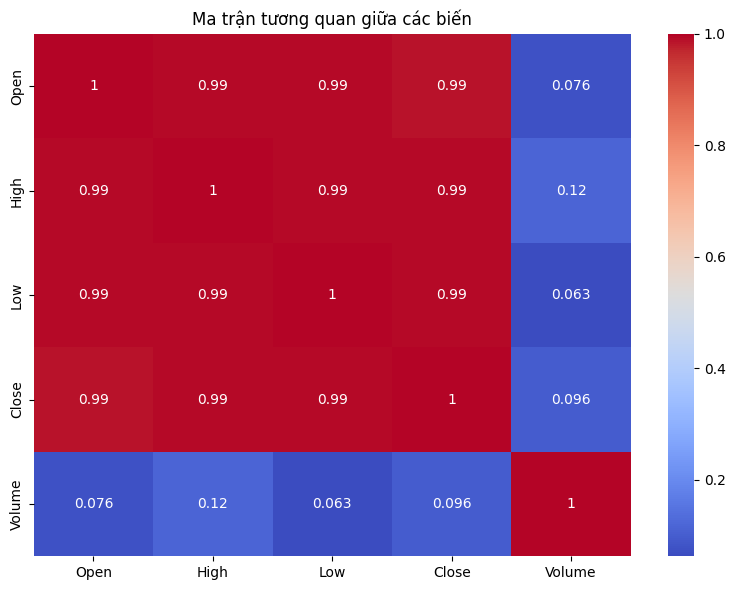

In [ ]:
# 1. Phân tích tương quan
plt.figure(figsize=(8,6))
corr = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan giữa các biến')
plt.tight_layout()
plt.show()

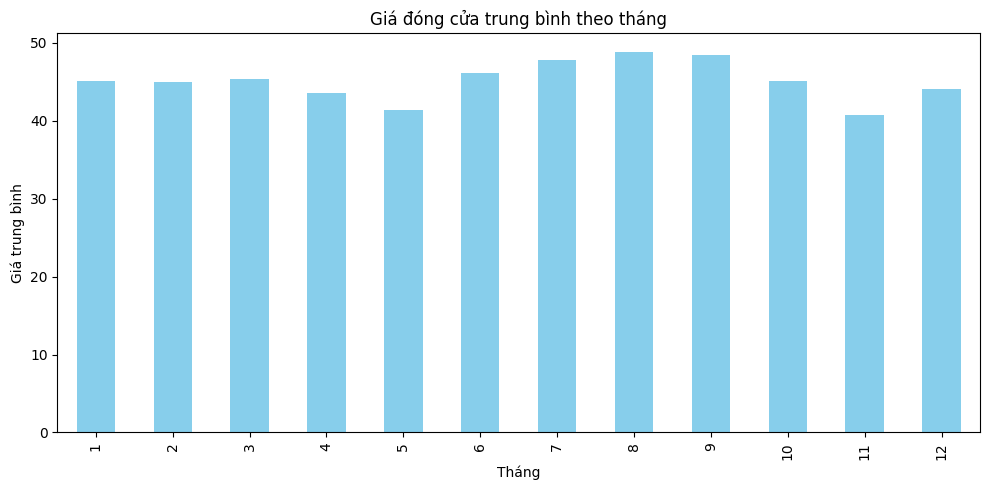

In [ ]:
# 2. Phân tích theo thời gian (tháng)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

plt.figure(figsize=(10,5))
df.groupby('Month')['Close'].mean().plot(kind='bar', color='skyblue')
plt.title('Giá đóng cửa trung bình theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Giá trung bình')
plt.tight_layout()
plt.show()

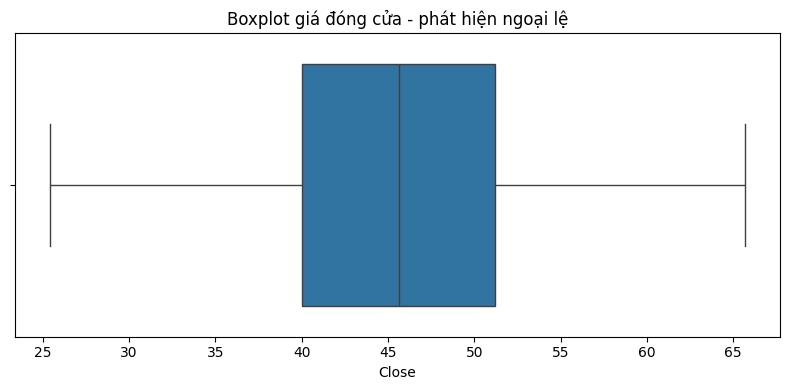

In [ ]:
# 3. Boxplot phát hiện ngoại lệ
plt.figure(figsize=(8,4))
sns.boxplot(x=df['Close'])
plt.title('Boxplot giá đóng cửa - phát hiện ngoại lệ')
plt.tight_layout()
plt.show()


In [ ]:
# === . Phân tích thống kê nhanh ===
summary = {
    'Giá cao nhất ': df['Close'].max(),
    'Giá thấp nhất ': df['Close'].min(),
    'Giá trung bình ': round(df['Close'].mean(), 2),
    'Biến động TB hàng ngày (%)': round(df['% Daily_Change'].abs().mean(), 2),
    'Khối lượng TB': round(df['Volume'].mean()),
    'Độ lệch chuẩn khối lượng': round(df['Volume'].std())
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Chỉ số', 'Giá trị'])
display(summary_df)


,Chỉ số,Giá trị
0,Giá cao nhất,65.70
1,Giá thấp nhất,25.40
2,Giá trung bình,45.14
3,Biến động TB hàng ngày (%),2.14
4,Khối lượng TB,1105206.00
5,Độ lệch chuẩn khối lượng,664609.00


In [ ]:
df.describe()

,Date,Close,Open,High,Low,Volume,% Daily_Change,Month,Year,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,EMA_50,RSI_14,MACD,Signal_Line
count,750,750.000000,750.000000,750.000000,750.000000,7.500000e+02,750.000000,750.000000,750.000000,741.000000,731.000000,701.000000,750.000000,750.000000,750.000000,737.000000,750.000000,750.000000
mean,2023-08-28 06:24:00.000000256,45.144800,45.200000,46.058267,44.325467,1.105206e+06,0.050640,6.632000,2023.146667,45.071579,45.003789,44.801749,45.135673,45.134909,45.193473,51.941184,-0.005408,-0.011843
min,2022-03-01 00:00:00,25.400000,23.600000,25.500000,23.600000,1.282000e+05,-7.000000,1.000000,2022.000000,28.090000,30.390000,31.344000,29.315759,30.381089,31.856716,10.344828,-5.473328,-4.988196
25%,2022-11-24 06:00:00,40.025000,40.000000,40.825000,39.300000,6.566750e+05,-1.425000,4.000000,2022.000000,40.550000,40.800000,41.160000,40.900706,40.962647,41.800705,38.636364,-0.623277,-0.525170
50%,2023-08-26 12:00:00,45.650000,45.700000,46.500000,44.800000,9.447000e+05,0.000000,7.000000,2023.000000,45.700000,45.475000,45.110000,45.886135,46.046843,45.554216,53.246753,0.132179,0.092041
75%,2024-05-30 18:00:00,51.200000,51.275000,51.900000,50.600000,1.387500e+06,1.590000,10.000000,2024.000000,51.180000,51.242500,51.440000,51.175702,51.390495,50.763329,65.333333,1.020181,0.956471
max,2025-02-28 00:00:00,65.700000,65.700000,67.900000,64.000000,5.340000e+06,7.000000,12.000000,2025.000000,64.080000,62.070000,58.010000,63.349349,61.532251,56.941585,89.763780,3.411787,3.193243
std,NaN,8.098302,8.107219,8.208474,8.037896,6.646091e+05,2.929431,3.418405,0.891936,7.920061,7.730677,7.163821,7.789564,7.475806,6.638924,17.406399,1.550099,1.449726


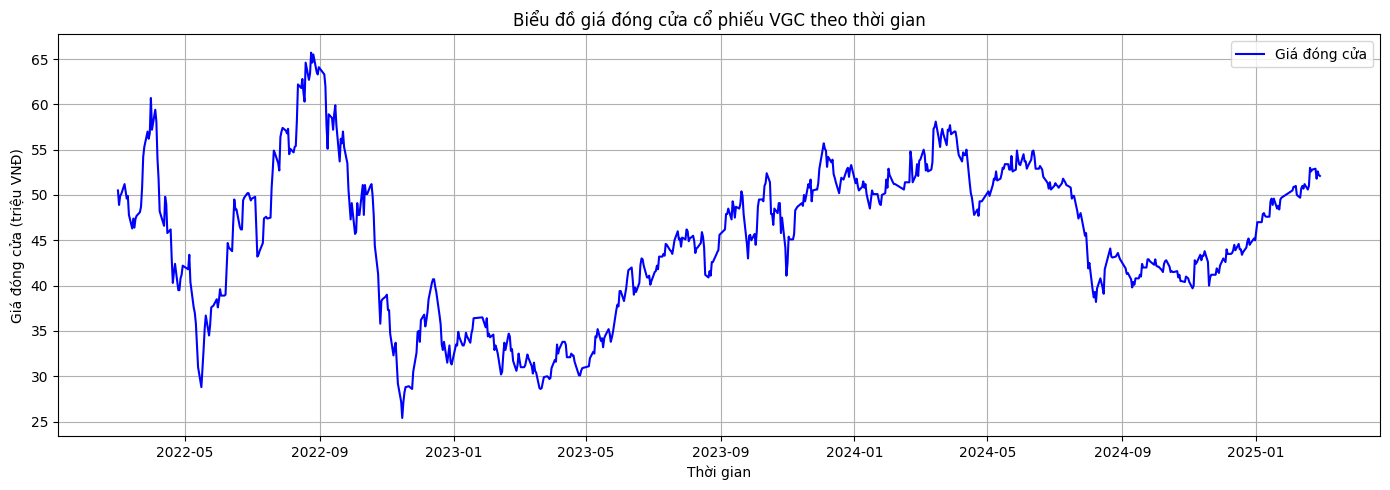

In [ ]:
# === 1. Biểu đồ line chart giá đóng cửa ===
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['Close'], label='Giá đóng cửa', color='blue')
plt.title('Biểu đồ giá đóng cửa cổ phiếu VGC theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (triệu VNĐ)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# === 2. Biểu đồ nến (candlestick chart) ===
fig = go.Figure(data=[go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])
fig.update_layout(title='Biểu đồ nến cổ phiếu VGC',
                  xaxis_title='Thời gian',
                  yaxis_title='Giá (triệu VNĐ)',
                  xaxis_rangeslider_visible=False,
                  template='plotly_white')
fig.show()


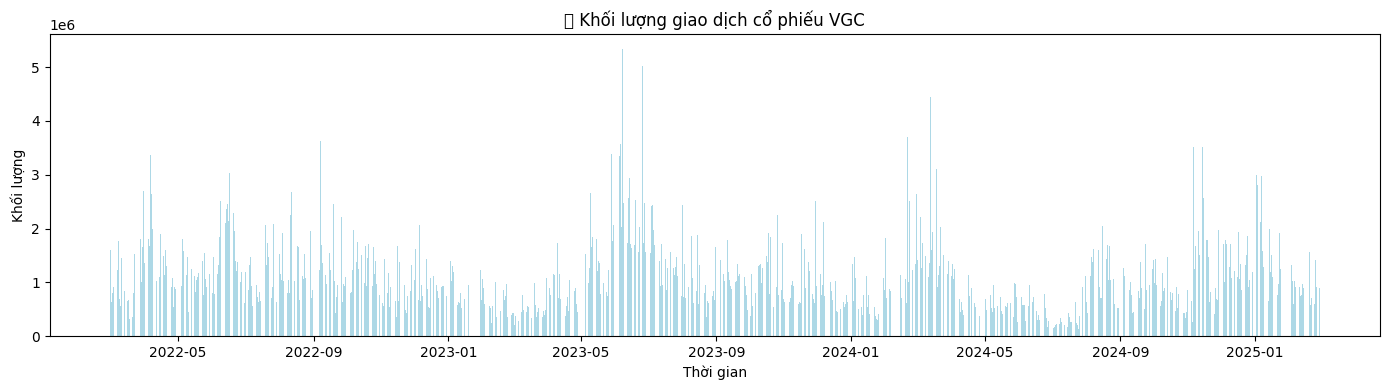

In [ ]:
# === 6. Biểu đồ Khối lượng giao dịch ===
plt.figure(figsize=(14, 4))
plt.bar(df['Date'], df['Volume'], color='lightblue')
plt.title("📊 Khối lượng giao dịch cổ phiếu VGC")
plt.xlabel("Thời gian")
plt.ylabel("Khối lượng")
plt.tight_layout()
plt.show()

In [ ]:
# Thống kê mô tả cho cột Close
desc = df['Close'].describe()
desc

,Close
count,750.000000
mean,45.144800
std,8.098302
min,25.400000
25%,40.025000
50%,45.650000
75%,51.200000
max,65.700000


# Các chỉ báo kĩ thuật


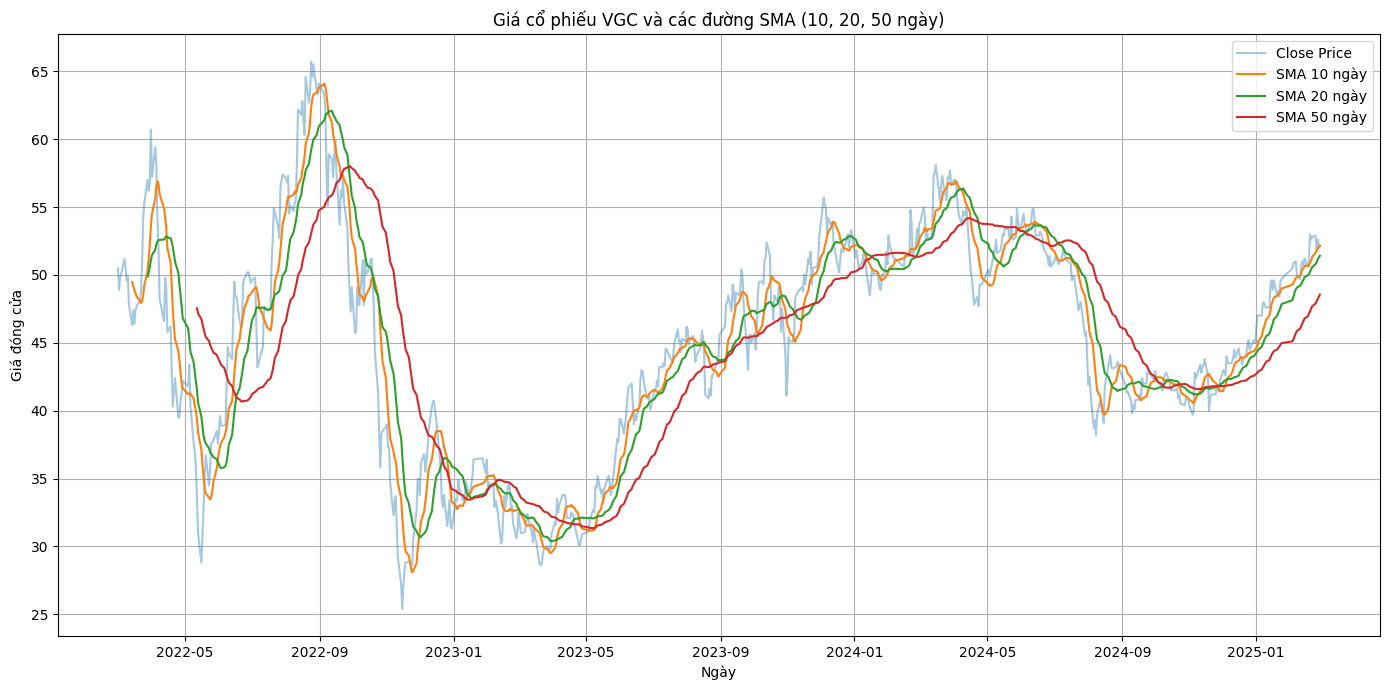

In [ ]:
#SMA # Tính các đường SMA
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['Date'], df['SMA_10'], label='SMA 10 ngày', linewidth=1.5)
plt.plot(df['Date'], df['SMA_20'], label='SMA 20 ngày', linewidth=1.5)
plt.plot(df['Date'], df['SMA_50'], label='SMA 50 ngày', linewidth=1.5)

plt.title('Giá cổ phiếu VGC và các đường SMA (10, 20, 50 ngày)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

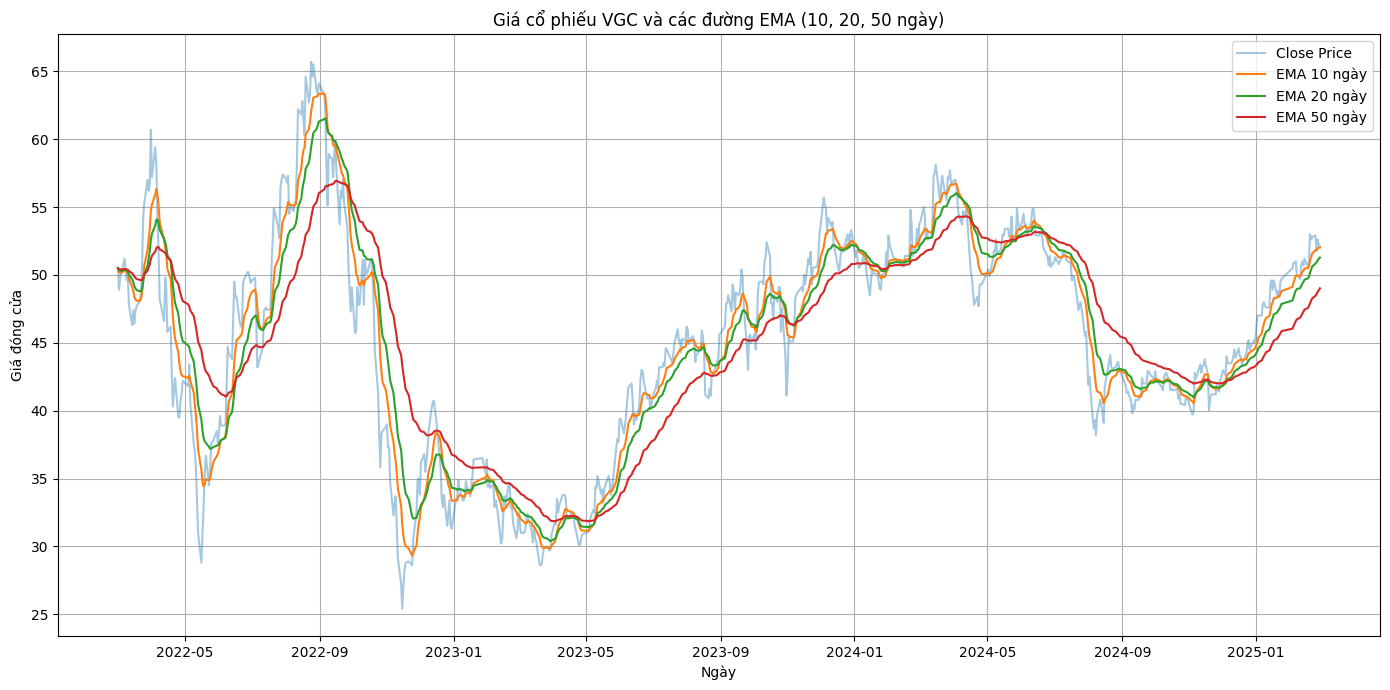

In [ ]:
# Tính các đường EMA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['Date'], df['EMA_10'], label='EMA 10 ngày', linewidth=1.5)
plt.plot(df['Date'], df['EMA_20'], label='EMA 20 ngày', linewidth=1.5)
plt.plot(df['Date'], df['EMA_50'], label='EMA 50 ngày', linewidth=1.5)

plt.title('Giá cổ phiếu VGC và các đường EMA (10, 20, 50 ngày)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


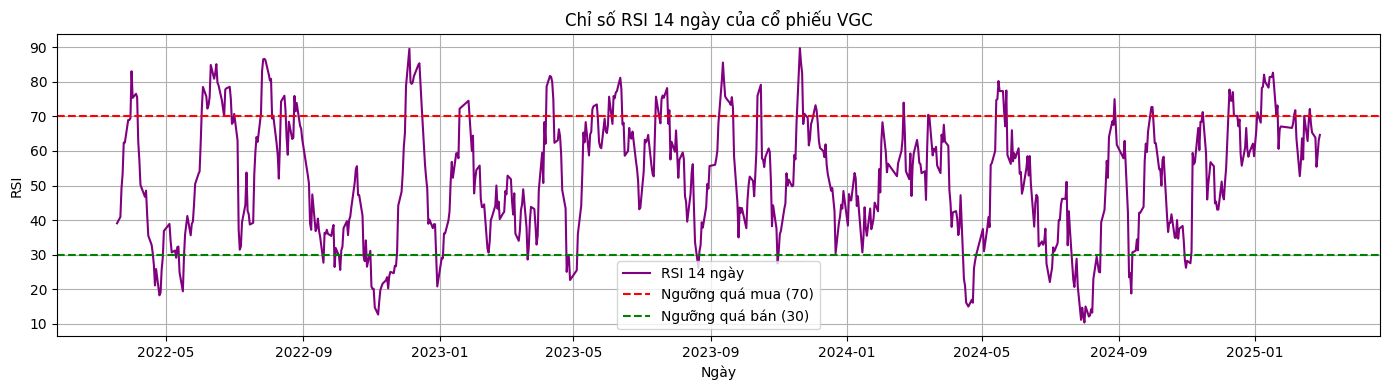

In [ ]:
# Tính RSI 14 ngày
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Vẽ biểu đồ RSI
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14 ngày', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Ngưỡng quá mua (70)')
plt.axhline(30, color='green', linestyle='--', label='Ngưỡng quá bán (30)')
plt.title('Chỉ số RSI 14 ngày của cổ phiếu VGC')
plt.xlabel('Ngày')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

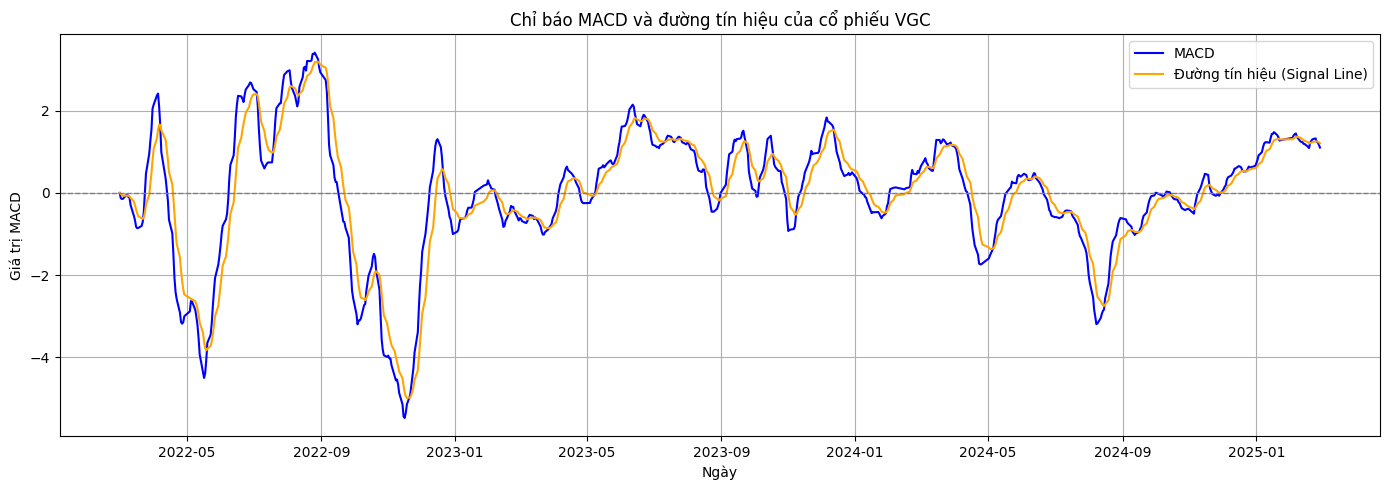

In [ ]:
# Tính MACD và Đường tín hiệu
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Vẽ biểu đồ MACD và đường tín hiệu
plt.figure(figsize=(14, 5))
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['Signal_Line'], label='Đường tín hiệu (Signal Line)', color='orange')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Chỉ báo MACD và đường tín hiệu của cổ phiếu VGC')
plt.xlabel('Ngày')
plt.ylabel('Giá trị MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Xây dựng mô hình dự báo

## LSTM


In [ ]:
import random
import os
import tensorflow as tf


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# Tạo tập dữ liệu với window = 30 ngày
def create_dataset(dataset, window_size=30):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 30)

In [ ]:
# Chia tập train/test 80/20
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [ ]:
# Reshape cho LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Xây dựng mô hình
set_seed(42)
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


In [ ]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [ ]:
# Dự đoán
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted_scaled), 1)), predicted_scaled], axis=1))[:, 1]
real = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)], axis=1))[:, 1]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
# Tạo trục thời gian cho phần test
dates = close_prices.index[30+split:]

In [ ]:
# Đánh giá sai số
r2_lstm = r2_score(real, predicted)
mae_lstm = mean_absolute_error(real, predicted)
rmse_lstm = np.sqrt(mean_squared_error(real, predicted))
mape_lstm = mean_absolute_percentage_error(real, predicted)
print(f"📈 R² của LSTM: {r2_lstm:.4f}")
print(f"📉 MAE của LSTM: {mae_lstm:.4f}")
print(f"📉 RMSE của LSTM: {rmse_lstm:.4f}")
print(f"📉 MAPE của LSTM: {mape_lstm:.4f}")

📈 R² của LSTM: 0.9406
📉 MAE của LSTM: 0.7063
📉 RMSE của LSTM: 0.9254
📉 MAPE của LSTM: 0.0163


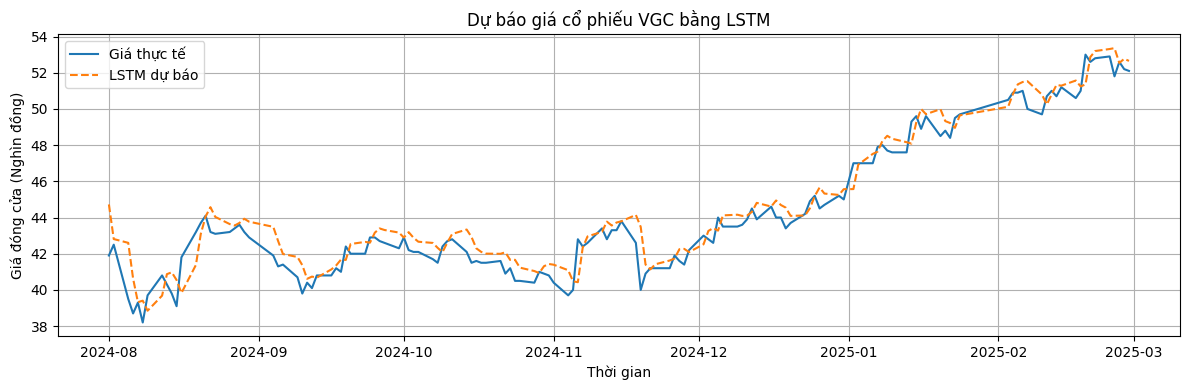

In [ ]:
# Vẽ biểu đồ so sánh kết quả dự báo và thức tế
plt.figure(figsize=(12, 4))
plt.plot(dates, real, label='Giá thực tế')
plt.plot(dates, predicted, label='LSTM dự báo', linestyle='--')
plt.title("Dự báo giá cổ phiếu VGC bằng LSTM")
plt.xlabel("Thời gian")
plt.ylabel("Giá đóng cửa (Nghìn đồng)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

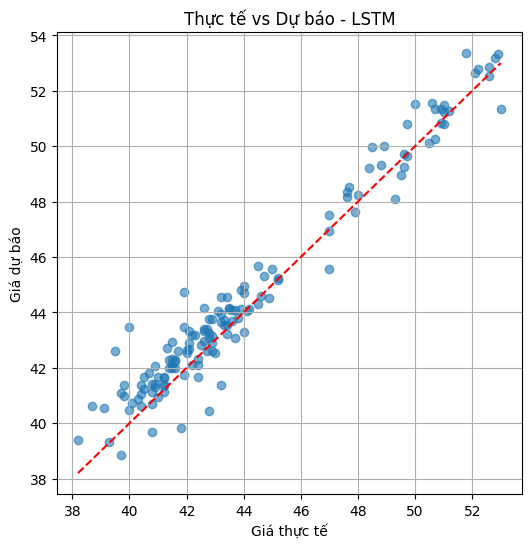

In [ ]:
# Biểu đồ scatter thực tế vs dự báo
plt.figure(figsize=(6,6))
plt.scatter(real, predicted, alpha=0.6)
plt.plot([real.min(), real.max()], [real.min(), real.max()], color='red', linestyle='--')
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự báo")
plt.title("Thực tế vs Dự báo - LSTM")
plt.grid(True)
plt.show()


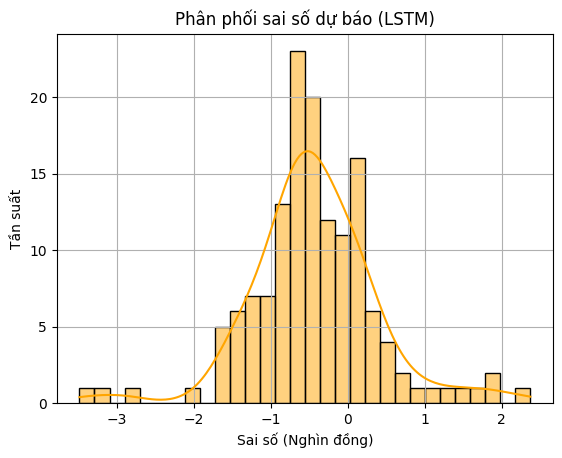

In [ ]:
#Biểu đồ phân phối sai số (Histogram) của LSTM
sns.histplot(real - predicted, bins=30, kde=True, color='orange')
plt.title("Phân phối sai số dự báo (LSTM)")
plt.xlabel("Sai số (Nghìn đồng)")
plt.ylabel("Tần suất")
plt.grid(True)
plt.show()

##Random Forest Regression


In [ ]:
# Sử dụng lại scaled_data đã được chuẩn hóa từ cột Close của LSTM

In [ ]:
# Tạo tập đặc trưng đầu vào (sliding window) cho Random Forest, giống với LSTM
def create_rf_dataset(dataset, window_size=30):
    X, y = [], []# Sử dụng lại scaled_data đã được chuẩn hóa từ cột Close

    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i, 0])  # Lấy 30 giá trị liền trước
        y.append(dataset[i, 0])                  # Giá trị cần dự báo
    return np.array(X), np.array(y)

In [ ]:
# Tạo X/y cho Random Forest với lookback = 30 (giống LSTM)
X_rf, y_rf = create_rf_dataset(scaled_data, 30)

# Chia train/test giống. hệt LSTM
split_rf = int(len(X_rf) * 0.8)
X_train_rf, y_train_rf = X_rf[:split_rf], y_rf[:split_rf]
X_test_rf, y_test_rf = X_rf[split_rf:], y_rf[split_rf:]

In [ ]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=42)

In [ ]:
# Dự đoán và inverse scale
predicted_rf_scaled = rf_model.predict(X_test_rf)
predicted_rf = scaler.inverse_transform(np.concatenate([np.zeros((len(predicted_rf_scaled), 1)), predicted_rf_scaled.reshape(-1, 1)], axis=1))[:, 1]
real_rf = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test_rf), 1)), y_test_rf.reshape(-1, 1)], axis=1))[:, 1]

In [ ]:
# Tính các chỉ số đánh giá
mae_rf = mean_absolute_error(real_rf, predicted_rf)
rmse_rf = np.sqrt(mean_squared_error(real_rf, predicted_rf))
mape_rf = mean_absolute_percentage_error(real_rf, predicted_rf)
r2_rf = r2_score(real_rf, predicted_rf)

print(f"📈 R² của Random Forest: {r2_rf:.4f}")
print(f"📉 MAE của Random Forest: {mae_rf:.4f}")
print(f"📉 RMSE của Random Forest: {rmse_rf:.4f}")
print(f"📉 MAPE của Random Forest: {mape_rf:.4f}")

📈 R² của Random Forest: 0.9374
📉 MAE của Random Forest: 0.7426
📉 RMSE của Random Forest: 0.9500
📉 MAPE của Random Forest: 0.0170


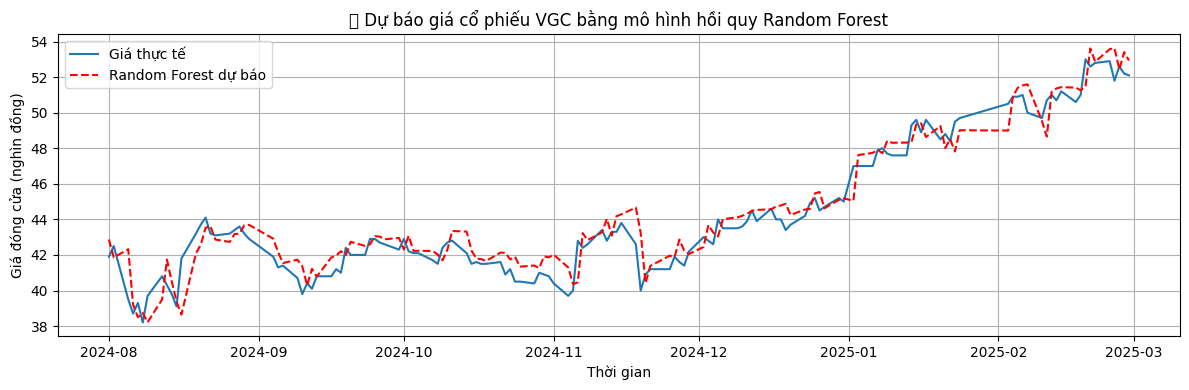

In [ ]:
# Vẽ biểu đồ so sánh dự báo của Random Forest với giá thực tế
plt.figure(figsize=(12, 4))
plt.plot(dates, real, label='Giá thực tế')
plt.plot(dates, predicted_rf, label='Random Forest dự báo', linestyle='--', color='red')
plt.title("📈 Dự báo giá cổ phiếu VGC bằng mô hình hồi quy Random Forest")
plt.xlabel("Thời gian")
plt.ylabel("Giá đóng cửa (nghìn đồng)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

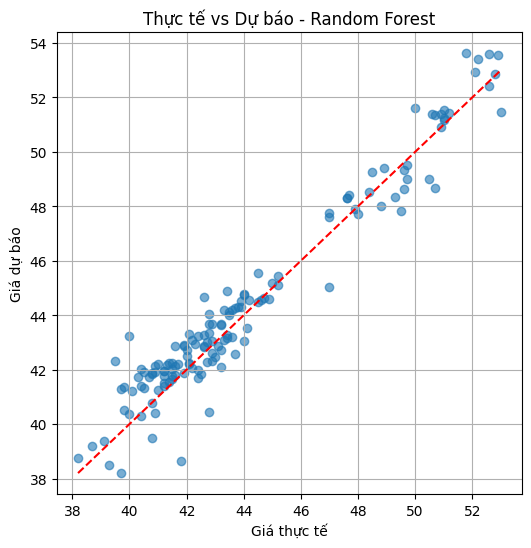

In [ ]:
# Biểu đồ scatter thực tế vs dự báo
plt.figure(figsize=(6,6))
plt.scatter(real, predicted_rf, alpha=0.6)
plt.plot([real.min(), real.max()], [real.min(), real.max()], color='red', linestyle='--')
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự báo")
plt.title("Thực tế vs Dự báo - Random Forest")
plt.grid(True)
plt.show()

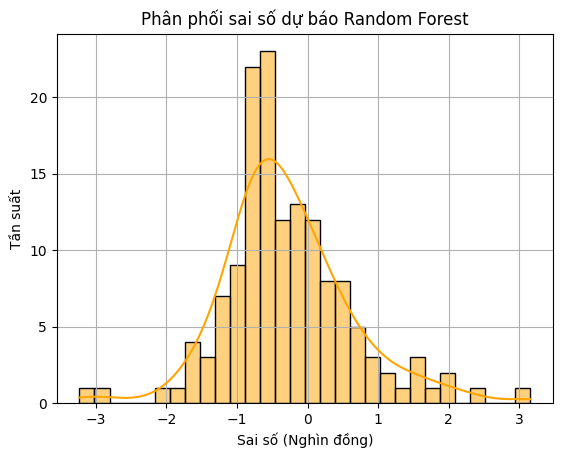

In [ ]:
#Biểu đồ phân phối sai số (Histogram) của LSTM
sns.histplot(real - predicted_rf, bins=30, kde=True, color='orange')
plt.title("Phân phối sai số dự báo Random Forest")
plt.xlabel("Sai số (Nghìn đồng)")
plt.ylabel("Tần suất")
plt.grid(True)
plt.show()